# Feature Selection - Wrapper Approach using a Genetic Algorithm
In this notebook we implement a rather simple feature selection procedure that follows a wrapper approach. The search algorithm, Genetic algorithms in this case, is wrapped around the target classification/regression algorithm.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# install the evolutionary computation library
!pip install deap

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn import datasets
from sklearn import linear_model
from sklearn import naive_bayes

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [4]:
data = datasets.load_boston()

X = data["data"]
y = data["target"]

number_of_variables = X.shape[1]
input_variables = data.feature_names
target_variable = 'MEDV'

seed = 1234
np.random.seed(seed)

# let's create also a pandas data frame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['MEDV'] = y
df.head()

kfolds = KFold(10,shuffle=True,random_state=seed)


In [5]:
def EvaluateFeatureSubsetSingleObjective(individual):
    selected_columns = []
    for i,allele in enumerate(individual):
        if (allele==1):
            selected_columns.append(df.columns[i])

    model = linear_model.LinearRegression()
    scores = cross_val_score(model, df[selected_columns], y, cv=kfolds)
    return scores.mean()

## Simple Genetic Algorithm
If looks for the feature subset that maximizes the overall performance.

We have a population which is initially generated randomly. As the problem proceed, instead of adding perturbations as done in Hill-Climbing, we select some individuals based on their fitness. We may have the same indidual repeated. We then shuffle the selected individuals. Then, given a pair of individuals, we combine them, generating what is called an **offspring**. Doing so, after combining all the individuals, we have a set of offsprings.

In [6]:
# We may have multiple fitness functions so we can specify the weights
# If we want to maximize the fitness function -> positive weights
# Otherwise -> negative weights
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# creator.create("Individual", list, typecode='b', fitness=creator.FitnessMax)

# Our individuals will be a list of elements
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, number_of_variables)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [7]:
toolbox.register("evaluate", EvaluateFeatureSubsetSingleObjective)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05) # indpb = flip-bit mutation prob.
toolbox.register("select", tools.selTournament, tournsize=3)

ngen: number of generations. In words, it is the number of time we do the process of generating a population and replace the old one with the new one. 

In [8]:
pop = toolbox.population(n=100)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg     	std     	min     	max     
0  	100   	0.512845	0.125035	0.234851	0.675068
1  	61    	0.602655	0.0527454	0.360924	0.676502
2  	56    	0.634393	0.0253045	0.577655	0.676502
3  	60    	0.654041	0.0188658	0.598184	0.676502
4  	59    	0.665382	0.0157153	0.582906	0.682203
5  	71    	0.671298	0.0097926	0.60405 	0.679957
6  	58    	0.672842	0.0158896	0.58827 	0.682264
7  	57    	0.676434	0.0101308	0.594975	0.683319
8  	69    	0.677967	0.00815522	0.604112	0.686291
9  	59    	0.677637	0.0123841 	0.58827 	0.686291
10 	51    	0.680008	0.00696449	0.632766	0.686291
11 	65    	0.68021 	0.0129861 	0.58827 	0.686291
12 	63    	0.682431	0.00993126	0.61548 	0.686291
13 	59    	0.68417 	0.00956652	0.607675	0.686291
14 	61    	0.683242	0.0118698 	0.61548 	0.686291
15 	62    	0.68412 	0.0105585 	0.61548 	0.686291
16 	60    	0.68096 	0.0280862 	0.420713	0.686291
17 	67    	0.682673	0.0233241 	0.45803 	0.686291
18 	56    	0.684249	0.0105827 	0.61548 	0.686291
19 	63    	0.683515	0.0119667 	

The performances, in this case, are not fair since in the previous example we had far less evaluations while here we have more.

In [13]:
average_fitness = [gen['avg'] for gen in log]
max_fitness = [gen['max'] for gen in log]
min_fitness = [gen['min'] for gen in log]
generations = [gen['gen'] for gen in log]

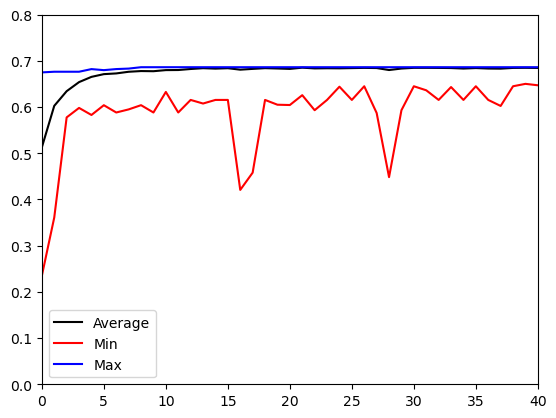

In [24]:
plt.plot(generations,average_fitness,label="Average",c="black")
plt.plot(generations,min_fitness,label="Min",c="red")
plt.plot(generations,max_fitness,label="Max",c="blue")
plt.axis([0,max(generations),0,.8])
plt.legend();

## Multi-objective Version
It applies a multi-objective genetic algorithm that tries to maximize the performance while minimizing the number of features involved.

The goal of feature-selection is to minimize the number of features so that the model consists of only those essential features but preserving the performances.

In [21]:
def EvaluateFeatureSubsetMultipleObjective(individual):
    '''returns the average performance and the number of features involved'''
    selected_columns = []
    for i, allele in enumerate(individual):
        if (allele==1):
            selected_columns.append(df.columns[i])

    if (len(selected_columns)>0):
        model = linear_model.LinearRegression()
        scores = cross_val_score(model, df[selected_columns], y, cv=kfolds)
        return scores.mean(), sum(individual)/float(len(individual))
    else:
        return 0, len(individual)

In [22]:
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
# Attribute generator
toolbox.register("attr_bool", random.randint, 0, 1)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, number_of_variables)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Operator registering
toolbox.register("evaluate", EvaluateFeatureSubsetMultipleObjective)
toolbox.register("mate", tools.cxUniform, indpb=0.1)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selNSGA2)

In [23]:
# random.seed(64)
MU, LAMBDA = 100, 200
pop = toolbox.population(n=MU)
hof = tools.ParetoFront()
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=MU, lambda_=LAMBDA,
                                         cxpb=0.7, mutpb=0.3, ngen=40, 
                                         stats=stats, halloffame=hof)

print("BEST "+str(hof[0]))


gen	nevals	avg                  	std                  	min                    	max                    
0  	100   	[0.5144469 0.5      ]	[0.1284796 0.1382477]	[0.20913642 0.15384615]	[0.6592851  0.84615385]
1  	200   	[0.56862494 0.46      ]	[0.12476931 0.16746633]	[0.19063885 0.15384615]	[0.66923613 0.76923077]
2  	200   	[0.58427195 0.43615385]	[0.12774033 0.1702956 ]	[0.15093595 0.15384615]	[0.66923613 0.76923077]
3  	200   	[0.62065805 0.44538462]	[0.08197667 0.1554893 ]	[0.19012883 0.07692308]	[0.66923613 0.76923077]
4  	200   	[0.60788886 0.39846154]	[0.10846255 0.16547582]	[0.19012883 0.07692308]	[0.67534841 0.69230769]
5  	200   	[0.56515301 0.31846154]	[0.15724671 0.17201211]	[0.19012883 0.07692308]	[0.6778203  0.69230769]
6  	200   	[0.49595302 0.28461538]	[0.21870413 0.17490488]	[0.19012883 0.07692308]	[0.67786589 0.69230769]
7  	200   	[0.65967014 0.41769231]	[0.02219335 0.10672921]	[0.4993403  0.07692308]	[0.67786589 0.61538462]
8  	200   	[0.65282483 0.35076923]	[0.0287779

In [27]:
average_fitness1 = [gen['avg'][0] for gen in logbook]
average_fitness2 = [gen['avg'][1] for gen in logbook]

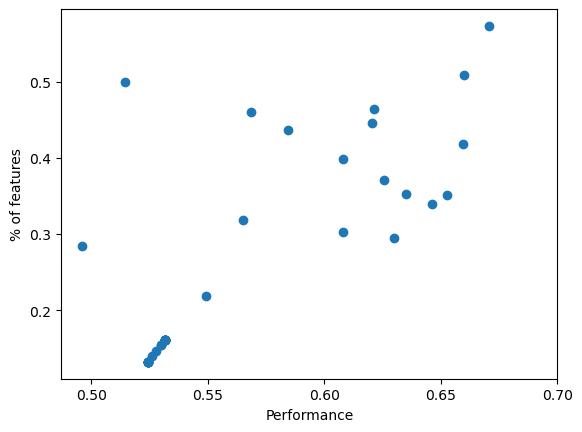

In [39]:
plt.scatter(average_fitness1, average_fitness2);
plt.xlabel("Performance")
plt.ylabel("% of features")
plt.xticks(np.arange(0.5, 0.71, 0.05))

## Discussion
Note that we applied genetic algorithms using the entire dataset for the evaluation of the feature subset. In a real scenario we should have initially split the data as train and test and then applied the genetic algorithm only using the training dataset.

We still need to have a test-set to assess the performance properly. Moreover, notice that the performances obtained are comparable.